<a href="https://colab.research.google.com/github/2303a51718/2303a51718-SESD-lab/blob/main/sesd%5Bproject%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install radon scikit-learn joblib pandas numpy shap tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.0 MB/s eta 0:00:00


In [2]:
import os
import math
import numpy as np
import pandas as pd
from radon.complexity import cc_visit
from radon.metrics import mi_visit, h_visit
from radon.raw import analyze

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from joblib import dump, load

import shap
import matplotlib.pyplot as plt


In [3]:
def build_synthetic_dataset(n=500):
    np.random.seed(42)

    loc = np.random.randint(200, 20000, n)
    cc = np.random.uniform(1, 10, n)
    vol = np.random.uniform(1000, 50000, n)

    # Synthetic MI formula (similar to radon)
    mi = 171 - 5.2*np.log(vol) - 0.23*cc - 16.2*np.log(loc)
    mi = mi + np.random.normal(0, 3, n)  # add noise

    df = pd.DataFrame({
        "loc_sum": loc,
        "avg_cc_mean": cc,
        "h_volume_sum": vol,
        "mi_label": mi
    })
    return df

df = build_synthetic_dataset()
df.head()


,loc_sum,avg_cc_mean,h_volume_sum,mi_label
0,15995,9.378362,24082.207182,-43.080843
1,1060,9.768234,9923.249802,12.897884
2,5590,9.963381,24754.139990,-17.769161
3,12164,1.502840,26110.425138,-35.250551
4,11484,7.633320,37342.660267,-36.746542


In [4]:
X = df.drop(columns=['mi_label'])
y = df['mi_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [6]:
preds = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("=== MODEL ACCURACY ===")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


=== MODEL ACCURACY ===
RMSE: 3.6632780279950388
MAE : 2.915535640798944
R²  : 0.9300026575069966


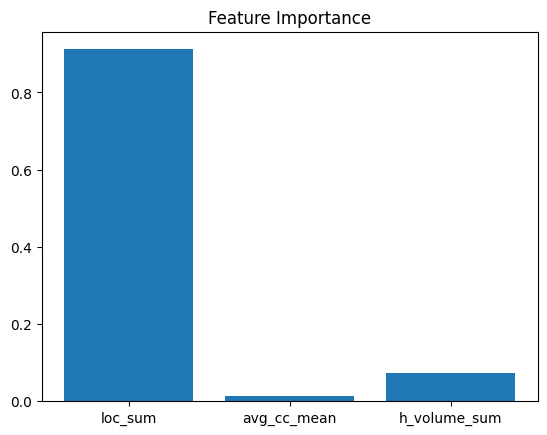

In [7]:
importances = model.feature_importances_
plt.bar(X.columns, importances)
plt.title("Feature Importance")
plt.show()


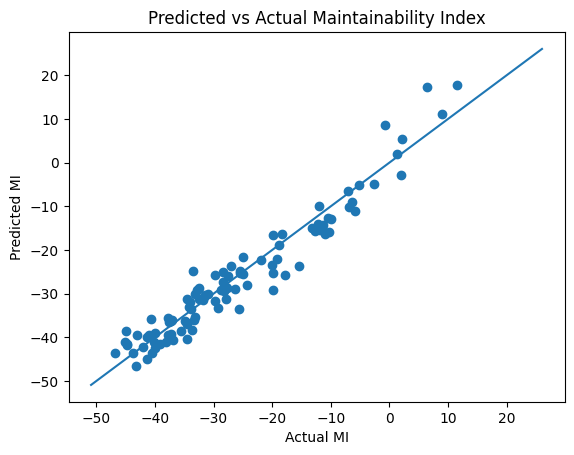

In [8]:
plt.scatter(y_test, preds)
plt.xlabel("Actual MI")
plt.ylabel("Predicted MI")
plt.title("Predicted vs Actual Maintainability Index")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()


/tmp/ipython-input-65400071.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


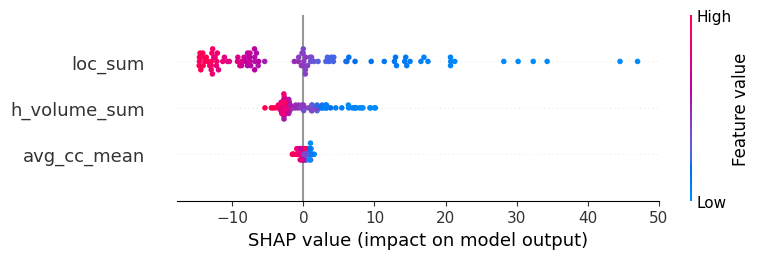

In [9]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
